# Formula learning

A toy example to learn a formula to predict a synthetic data


Let's say we have a regression problem to predict a target value in $\cal{R}$. 
Input data has $M$ features and a target is computed as 
$$
y_{i} = f(\mathbf x)
$$
we will try various functions $f$ to observe ability to learn it using a DNN.

## A warm-up

Let us predict a simple function : $f(\mathbf x) = 1 + \sum_{i} x_i$

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [31]:
import os

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline


n_samples = 10000
n_features = 10
x_max = 100.0
x_min = -100.0
trainval_x = (x_max - x_min) * np.random.rand(n_samples, n_features) + x_min
test_x = (x_max - x_min) * np.random.rand(n_samples//5, n_features) + x_min

In [32]:
def f(x):
    return np.sum(x) + 1.0

In [33]:
trainval_y = np.zeros((n_samples, 1))
test_y = np.zeros((n_samples//5, 1))

for i, x in enumerate(trainval_x):
    trainval_y[i, 0] = f(x)
    
for i, x in enumerate(test_x):
    test_y[i, 0] = f(x)    

In [34]:
import pandas as pd
import seaborn as sns

cols_x = ['x_%i' % i for i in range(n_features)]
df = pd.DataFrame(data=trainval_x, columns=cols_x)
df['y'] = trainval_y

In [35]:
df.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y
0,-6.231932,-5.882621,24.613055,62.417919,97.075089,78.385178,-38.475568,48.600158,-10.755354,-10.509969,240.235956
1,-18.290302,-14.230423,-77.131978,-80.916952,-53.688595,0.227387,34.309633,36.703977,-25.116072,25.119051,-172.014275
2,79.403377,22.613168,41.840953,-55.032196,59.038406,49.490027,9.439954,3.065606,65.196460,41.854745,317.910502
3,56.457412,-61.270650,52.070623,-41.730357,24.035111,-35.312342,-31.665951,-5.372767,37.465681,-44.950515,-49.273756
4,15.008415,72.501280,-21.445808,82.310602,-20.426569,-89.551883,-41.966660,8.089957,-80.264190,72.421122,-2.323734


In [36]:
df.loc[0, ['x_%i' % i for i in range(10)]].sum() + 1.0, df.loc[1, ['x_%i' % i for i in range(10)]].sum() + 1.0 

(240.23595575059119, -172.01427478333477)

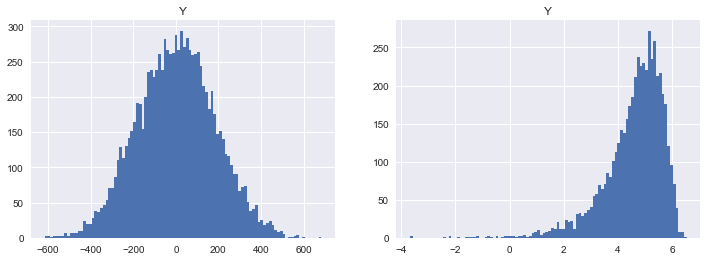

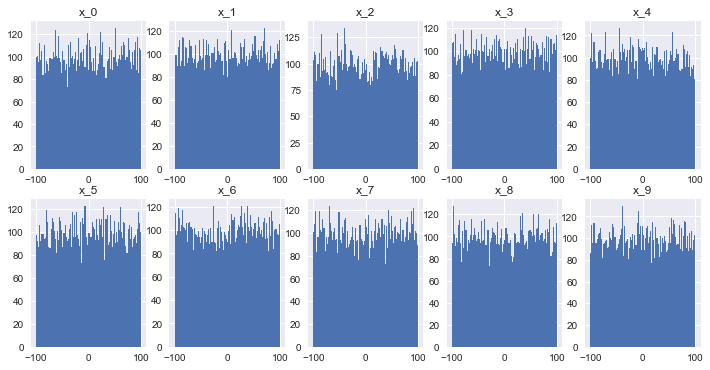

In [37]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
df['y'].hist(bins=100)
plt.title('Y')
plt.subplot(122)
df['y'].apply(np.log).hist(bins=100)
plt.title('Y')

plt.figure(figsize=(12, 6))
for i in range(n_features):
    plt.subplot(2, n_features/2, i+1)
    df['x_%i' % i].hist(bins=100)
    plt.title('x_%i' % i)

### Define a NN


Let's define a model as  
$$
f_{nn}(\mathbf x) = b_i + \langle W_i, \mathbf x \rangle,
$$

In [38]:
import tensorflow as tf

from tf_bike.train import Trainer

In [39]:
def nn(x):    
    b = tf.Variable(tf.random_uniform((1,)), name='b')
    W = tf.Variable(tf.random_uniform((x.get_shape().as_list()[1], 1)), name='W') 
    return tf.add(b, tf.matmul(x, W), name='trivial_regression_model')

In [40]:
def np_loss(y_true, y_pred):
    return np.mean(np.mean(np.power(y_true - y_pred, 2.0), axis=-1))

def tf_loss(Y_true, Y_pred):
    return tf.reduce_mean(tf.reduce_mean(tf.square(Y_true - Y_pred), axis=-1))

def tf_rmse(Y_true, Y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.square(Y_true - Y_pred), axis=-1)))

In [41]:
tf.reset_default_graph()
y_true = np.ones((100, 1))
y_pred = np.linspace(-2, 2, num=100).reshape((100, 1))

lss = np_loss(y_true, y_pred)

with tf.Session() as sess:    
    Y_true = tf.placeholder(tf.float32, shape=(None, 1))
    Y_pred = tf.placeholder(tf.float32, shape=(None, 1))
    lss2, rmse = sess.run([tf_loss(Y_true, Y_pred), tf_rmse(Y_true, Y_pred)], feed_dict={Y_true: y_true, Y_pred: y_pred})

print("Loss numpy :", lss)
print("Loss tf :", lss2)
print("RMSE :", rmse)
    

Loss numpy : 2.36026936027
Loss tf : 2.36027
RMSE : 1.25758


In [42]:
from datetime import datetime
trainer = Trainer(log_dir='logs_{}'.format(datetime.now().strftime("%Y-%m-%d-%H-%M")))

In [43]:
train_params = {        
    # Network
    'network': nn,
    
    # Loss
    'loss': tf_loss,
    
    # Optimizer
    'optimizer': tf.train.GradientDescentOptimizer,
    
    # Metrics
    'metrics': [
        ('rmse', tf_rmse),
    ],
    
    # Learning rate params
    'lr': tf.train.piecewise_constant,
    'lr_kwargs': {
        'boundaries': [150, 250, 350],
        'values': [0.0001, 0.00007, 0.00003]
    },
    
    # Pretrained model
    # 'pretrained_model': "/path/to/pretrained/model.ckpt",
    
    'training_epochs': 1200,
    'batch_size': 512,
    
    'seed': 2017,
    
}

In [44]:
trainer.train(trainval_x, trainval_y, 
              training_params=train_params, 
              verbose=1)

Start training
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path logs_2017-06-29-16-51\train\Model/trivial_regression_model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch: 0100
loss=0.135099443 | rmse=0.367098855 
val_loss=0.134673279 | val_rmse=0.366833970 
Epoch: 0200
loss=0.114207557 | rmse=0.337523058 
val_loss=0.113845581 | val_rmse=0.337277055 
Epoch: 0300
loss=0.096547297 | rmse=0.310331956 
val_loss=0.096240858 | val_rmse=0.310104847 
Epoch: 0400
loss=0.081617978 | rmse=0.285331036 
val_loss=0.081359252 | val_rmse=0.285122991 
Epoch: 0500
loss=0.068996556 | rmse=0.262343194 
val_loss=0.068777705 | val_rmse=0.262151644 
Epoch: 0600
loss=0.058327617 | rmse=0.241208896 
val_loss=0.058141877 | val_rmse=0.241031203 
Epoch: 0700
loss=0.049307533 | rmse=0.221775150 
val_loss=0.049151913 | val_rmse=0.221614990 
Epoch: 0800
loss=0.041682618 | rmse=0.203907720 
val_loss=0.041550934 | val_rmse=0.203760143 
Epoch: 0900
loss=0.035237425 | rmse=0.18748

(2000, 10)

## A ratio-like and squared formula

Let $M=10$ and the function to learn is defined as 
$$
f(\mathbf x) = \frac{\sum_i a_i x_i + b} {\sum_i c_i x_i + d} + \alpha \sum_{i,j \neq i} x_i x_j + \beta
$$
where coefficients $a_i$, $b$, $c_i$, $d$, $\alpha$, $\beta$ are randomly chosen.

Setup input data :

In [ ]:
import os
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

n_samples = 10000
n_features = 10
a = np.random.rand(n_features)
b = 1.0
c = np.random.rand(n_features)
d = np.random.rand() * 100.0
alpha = np.random.rand() * 1.0 / 50.0
beta = np.random.rand() * 50.0

x_max = 100.0
x_min = -50.0
trainval_x = (x_max - x_min) * np.random.rand(n_samples, n_features) + x_min

In [ ]:
def f(sample_x):
    numerator = np.dot(a, sample_x) + b
    denominator = np.dot(c, sample_x) + d
    t1 = numerator / denominator
    
    t2 = 0
    for v in sample_x:
        t2 += v * (np.sum(sample_x) - v)    
    t2 *= alpha
    return t1 + t2 + beta

In [ ]:
trainval_y = np.zeros((n_samples, 1))
for i, x in enumerate(trainval_x):
    trainval_y[i] = f(x)

In [ ]:
import pandas as pd
import seaborn as sns

cols_x = ['x_%i' % i for i in range(n_features)]
df = pd.DataFrame(data=trainval_x, columns=cols_x)
df['y'] = trainval_y

In [ ]:
df.head()

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
df['y'].hist(bins=100)
plt.title('Y')
plt.subplot(122)
df['y'].apply(np.log).hist(bins=100)
plt.title('Y')

# plt.figure(figsize=(12, 6))
# for i in range(n_features):
#     plt.subplot(2, n_features/2, i+1)
#     df['x_%i' % i].hist(bins=100)
#     plt.title('x_%i' % i)

### Define a NN


Let's define a model as  
$$
f_{nn}(\mathbf x) = \prod_{i=0}^{l-1} \left( b_i + \langle W_i, g(\mathbf x) \rangle \right),
$$
where 
$$
g(\mathbf x) = g_m(\mathbf x) = h^{(1)}_{m,m-1}(\mathbf x) + \frac{1}{\epsilon + h^{(2)}_{m,m-1}(\mathbf x)}
$$
and 
$$
h^{(i)}_{m,m-1}(\mathbf x) = \text{activation}(\langle W_{i,m}, g_{m-1}(\mathbf x) \rangle + b_{i,m}), \\
g_{0} (\mathbf x) = \mathbf x
$$


In [ ]:
import tensorflow as tf

In [ ]:
def tf_rmse(Y_true, Y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.square(Y_true - Y_pred), axis=-1)))

def tf_loss(Y_true, Y_pred):
    l1 = tf.reduce_mean(tf.reduce_mean(tf.square(Y_true - Y_pred), axis=-1))
    l2 = tf.log(1.0 + tf_rmse(Y_true, Y_pred))
    return tf.minimum(l1, l2)

In [ ]:
with tf.Session() as sess:
    n = 100
    Y_true = tf.placeholder(tf.float32, shape=(None, 1))
    Y_pred = tf.placeholder(tf.float32, shape=(None, 1))
    loss = np.zeros((n,))
    yspan = np.linspace(-20, 20, num=n)
    for i, v in enumerate(yspan):
        y_true = np.ones((1, 1))
        y_pred = np.array(v).reshape((1, 1))
        loss[i] = sess.run(tf_loss(Y_true, Y_pred), feed_dict={Y_true: y_true, Y_pred: y_pred})

plt.figure()
plt.plot(yspan, loss, label='loss')
plt.legend()


In [ ]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, n_features))
Y_true = tf.placeholder(tf.float32, shape=(None, 1))

train_params = {    
    
#     'lr_kwargs': {
#         'boundaries': [50, 100, 200, 500, 1000, ],
#         'values': [1e-3, 1e-4, 5*1e-5, 0.000001, 0.0000001]
#     },
#     'lr_f': tf.train.piecewise_constant,        
    
    'lr_kwargs': {
        'decay_steps': 100,
        'decay_rate': 0.9,
        'learning_rate': 0.005,
        'staircase': True
    },
    'lr_f': lambda x, **kwargs: tf.train.exponential_decay(global_step=x, **kwargs),
    
    'training_epochs': 5000,
    'batch_size': 1024,
    
    'seed': 2017,
    
    # Tensorboard
    'logs_path': 'logs'
}

In [ ]:
epsilon = tf.constant(1e-10)

def h(index, m, x, n_filters, with_activation=True):    
    b = tf.Variable(tf.random_uniform([n_filters]), 
                    name='bias_%i_%i' % (index, m))
    W = tf.Variable(tf.random_uniform(shape=[x.get_shape().as_list()[1], n_filters]), 
                    name="W_%i_%i" % (index, m))
    
    name = name='h_%i_%i' % (index, m)
    out = tf.add(tf.matmul(x, W), b)
    if with_activation:
        return tf.nn.elu(out, name=name)
    else:
        return tf.identity(out, name=name)
    
    
def g(m, x, n_filters_list):        
    _x = x if m == 0 else g(m-1, x, n_filters_list)
    inv_h2 = tf.divide(tf.constant(1.0), tf.add(epsilon, h(2, m, _x, n_filters_list[m])))
    return tf.add(h(1, m, _x, n_filters_list[m]), inv_h2, name='g_%i' % m)


def nn(x, k, m):    
    nf = 5
    n_filters_list = [nf for j in range(m)]       
    net = h(3, 0, g(m-1, x, n_filters_list), n_filters=1, with_activation=False)
    for i in range(1, k):
        n_filters_list = [nf for j in range(m)]               
        net = tf.multiply(net, h(3, 0, g(m-1, x, n_filters_list), n_filters=1, with_activation=False))
    return net
    

In [ ]:
# Construct model and encapsulating all ops into scopes, making
# Tensorboard's Graph visualization more convenient
with tf.name_scope('Model'):
    # Model
    Y_pred = nn(X, k=2, m=3)
    
with tf.name_scope('Loss'):
    # Minimize error using MAE
    loss = tf_loss(Y_true, Y_pred)
    
with tf.name_scope('Optimizer'):
    # Gradient Descent
    global_step = tf.Variable(0, trainable=False)    
    lr_f = train_params['lr_f'](global_step, **train_params['lr_kwargs'])    
    optimizer = tf.train.GradientDescentOptimizer(lr_f).minimize(loss)
    
with tf.name_scope('RMSE'):
    # Accuracy    
    rmse = tf_rmse(Y_true, Y_pred)

# Create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("RMSE", rmse)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

In [ ]:
from datetime import datetime
from sklearn.model_selection import train_test_split

verbose = 1
display_step = 10

# Launch the graph
tf.set_random_seed(train_params['seed'])
print("Start training")
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())    
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(os.path.join(train_params['logs_path'], 
                                                        'run_%s' % str(datetime.now().strftime("%Y-%m-%d-%H-%M"))), 
                                           graph=sess.graph)

    
    batch_size = train_params['batch_size']        
    train_x, val_x, train_y, val_y = train_test_split(trainval_x, trainval_y, train_size=0.75)
    
    n_train_batchs = int(train_x.shape[0]/batch_size)
    n_val_batchs = int(val_x.shape[0]/batch_size)    
    
    # Training cycle
    for epoch in range(train_params['training_epochs']):
               
        if verbose > 0 and (epoch+1) % display_step == 0:
            print("Epoch: %04d" % (epoch+1))
        
        avg_loss = 0.0
        avg_rmse = 0.0
        # Train over all batches
        lr = sess.run(lr_f, feed_dict={global_step: epoch})
        for i in range(n_train_batchs):

            if verbose > 1:
                print("-- %i / %i" % (i, n_train_batchs))

            
            i_start = batch_size*i
            i_end = batch_size*(i+1)
            batch_xs, batch_ys = train_x[i_start:i_end,:], train_y[i_start:i_end, :] 
            # Run optimization op (backprop), loss op (to get loss value)
            # and summary nodes
            run_options = None
            run_metadata = None
            if i % 100 == 99:
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()
            _, l, r, y_pred, summary = sess.run([optimizer, loss, rmse, Y_pred, merged_summary_op],
                                                feed_dict={X: batch_xs, Y_true: batch_ys}, 
                                                run_metadata=run_metadata, options=run_options)
            
            if verbose > 2:
                print("Numpy Loss: %f" % np_loss(batch_ys, y_pred))
                print("TF Loss: %f" % l)
                print("TF RMSE: %f" % r)
                
            # Write logs at every iteration
            summary_writer.add_summary(summary, epoch * n_train_batchs + i)
            
            # Compute average loss
            avg_loss += l * 1.0 / n_train_batchs
            avg_rmse += r * 1.0 / n_train_batchs            
            
        # Display logs per epoch step
        if verbose > 0 and (epoch+1) % display_step == 0:
            print("loss=%.9f, rmse=%.9f | lr=%f" % (avg_loss, avg_rmse, lr))
        
        # Validation
        avg_loss = 0.0
        avg_rmse = 0.0        
        for i in range(n_val_batchs):
            i_start = batch_size*i
            i_end = batch_size*(i+1)
            batch_xs, batch_ys = val_x[i_start:i_end,:], val_y[i_start:i_end, :] 
            # Run optimization op (backprop), loss op (to get loss value)
            # and summary nodes
            run_options = None
            run_metadata = None
            if i % 100 == 99:
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()
            
            l, r, summary = sess.run([loss, rmse, merged_summary_op], 
                                     feed_dict={X: batch_xs, Y_true: batch_ys}, 
                                     run_metadata=run_metadata, options=run_options)
            # Compute average loss
            avg_loss += l / n_val_batchs
            avg_rmse += r / n_val_batchs            
            
        # Display logs per epoch step
        if verbose > 0 and (epoch+1) % display_step == 0:
            print("val_loss=%.9f, val_rmse=%.9f" % (avg_loss, avg_rmse))

    print("Optimization Finished!")
